<H1 align="middle">Extreme Gradient Boost for Disease Spread Prediction</H1>

<br>
<strong>This notebook trains a extreme gradient boost-based classification model on the training dataset and predicts on the testing dataset</strong>

## Import Libraries

### Python Libraries

In [1]:
import warnings

### External Libraries

In [2]:
from sklearn.model_selection import train_test_split
import dask.array as da
import xgboost as xgb
from dask.distributed import Client

### Custom Libraries

In [3]:
from utils_data import PopulationData
from utils_evaluation import evaluate_numpy
from utils_plot import plot_confusion_matrix, plot_roc

## Setup Environment

### Suppress Warnings

In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Set Parameters

### Select Features

In [5]:
features = ['Normalized_Age',
            'Normalized_Behaviour',
            'Normalized_Constitution',
            'Normalized_Degree',
            'Normalized_Distance_to_Index_Patient',
            'Normalized_Sum_Neighbor_Age',
            'Normalized_Sum_Neighbor_Behaviour',
            'Normalized_Sum_Neighbor_Constitution',
            'Normalized_Sum_Neighbor_Degree',
            'Normalized_Sum_Population_Age',
            'Normalized_Sum_Population_Behaviour',
            'Normalized_Sum_Population_Constitution',
            'Normalized_Sum_Population_Distance_to_Index_Patient']

### Set Model Parameters

In [6]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'error',
    'n_estimators': 256
}

## Initialize Dask Cluster

In [7]:
client = Client()

## Load Data

### Load Processed Training Data

In [8]:
train_data = PopulationData().load_processed('../../data/processed/train.csv')

### Load Processed Testing Data

In [9]:
test_data = PopulationData().load_processed('../../data/processed/test.csv')

### Split Train Eval Data

In [10]:
train_features, train_labels = train_data.get_feature_label_numpy(features=features)
train_features, eval_features, train_labels, eval_labels = train_test_split(train_features, train_labels, test_size=0.2)

## Get id and Test Data

In [11]:
test_ids, test_features = test_data.get_id_feature_numpy(features=features)

### Convert Train and Eval Data to Dask Arrays

In [12]:
train_features = da.from_array(train_features, chunks=1000)
eval_features = da.from_array(eval_features, chunks=1000)
train_labels = da.from_array(train_labels, chunks=1000)
eval_labels = da.from_array(eval_labels, chunks=1000)

### Convert Test Data to Dask Array

In [13]:
test_features = da.from_array(test_features, chunks=1000)

### Create Train and Eval Dask DMatrix

In [14]:
dtrain = xgb.dask.DaskDMatrix(client, train_features, train_labels)
deval = xgb.dask.DaskDMatrix(client, eval_features, eval_labels)

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


### Create Test Dask DMatrix

In [15]:
dtest = xgb.dask.DaskDMatrix(client, test_features)

Windows is not officially supported for dask/xgboost, contribution are welcomed.


## Create Model

In [16]:
model = xgb.XGBClassifier(**params, use_label_encoder=False)

## Train Model

In [17]:
model.fit(train_features, train_labels, eval_set=[(eval_features, eval_labels)], verbose=True)

[0]	validation_0-error:0.40177
[1]	validation_0-error:0.31556
[2]	validation_0-error:0.26407
[3]	validation_0-error:0.24039
[4]	validation_0-error:0.22782
[5]	validation_0-error:0.22138
[6]	validation_0-error:0.21564
[7]	validation_0-error:0.21169
[8]	validation_0-error:0.20885
[9]	validation_0-error:0.20622
[10]	validation_0-error:0.20620
[11]	validation_0-error:0.20579
[12]	validation_0-error:0.20482
[13]	validation_0-error:0.20512
[14]	validation_0-error:0.20455
[15]	validation_0-error:0.20458
[16]	validation_0-error:0.20363
[17]	validation_0-error:0.20306
[18]	validation_0-error:0.20208
[19]	validation_0-error:0.20153
[20]	validation_0-error:0.20203
[21]	validation_0-error:0.20161
[22]	validation_0-error:0.20131
[23]	validation_0-error:0.20061
[24]	validation_0-error:0.20084
[25]	validation_0-error:0.20053
[26]	validation_0-error:0.20059
[27]	validation_0-error:0.20025
[28]	validation_0-error:0.20002
[29]	validation_0-error:0.20007
[30]	validation_0-error:0.19998
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=256,
              n_jobs=None, num_parallel_tree=None, ...)

## Evaluate Model

### Predict on Eval Data

In [18]:
eval_predicted = model.predict(eval_features)
eval_probabilities = model.predict_proba(eval_features)
eval_probabilities = eval_probabilities[:, 1]

### Compute Evaluation Metrics

In [19]:
accuracy, precision, recall, f1, auc_roc, confusion_matrix = evaluate_numpy(eval_predicted,
                                                                            eval_probabilities,
                                                                            eval_labels)

### Print Evaluation Metrics

In [20]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.8036
Precision: 0.7296
Recall: 0.9223
F1: 0.8147
AUC-ROC: 0.8716


## Plot Evaluation Metrics

### Plot Confusion Matrix

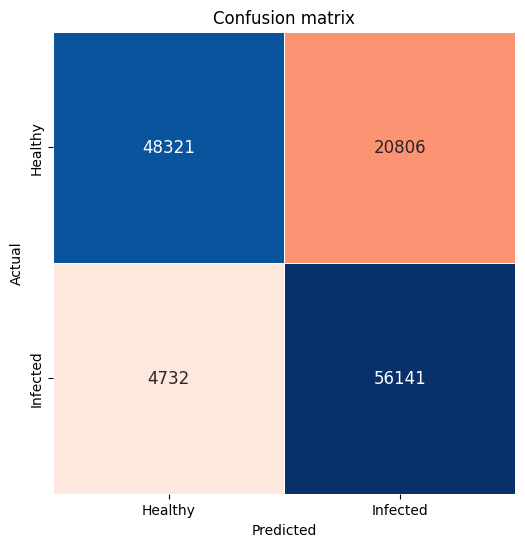

In [21]:
plot_confusion_matrix(confusion_matrix, ['Healthy', 'Infected'])

### Plot ROC

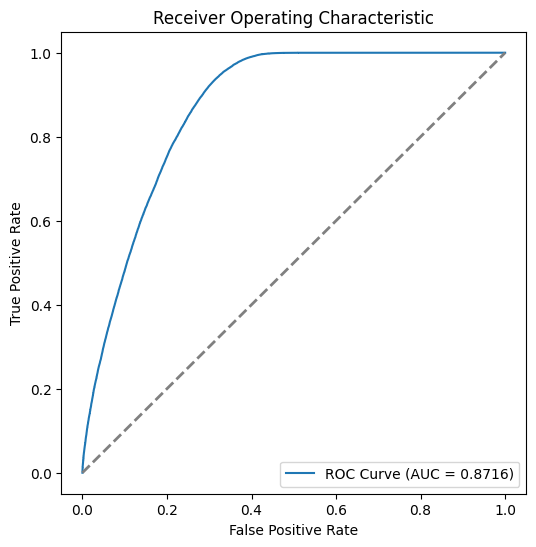

In [22]:
plot_roc(eval_probabilities, eval_labels)

## Save Model

In [23]:
model.save_model("../../models/xgb_model.json")

## Predict on Test Data

In [24]:
test_probabilities = model.predict_proba(test_features)
test_probabilities = test_probabilities[:, 1]

## Save Predictions

In [25]:
test_data.save_predicted_probabilities("../../data/out/xgb_predictions.csv", test_probabilities)